# 4 Simple Solar PV and Battery Storage

This notebook provides an example of how to run the PV + Battery model controller. This system contains weather data, a house load, a grid connection with fixed or agile prices, and a simple 'load following' battery control which discharges to match the house load and charges from available solar PV (this reflects how the vast majority of domestic scale grid tied battery systems in the UK operate).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import importlib
from datetime import datetime,tzinfo,timezone,timedelta
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import electrichouse as eh
from electrichouse.controllers import  PlanController,do_nothing_step_function
from electrichouse.components.inputs import (
    TempAndPVInputParams,
    TempAndPVComponent,
    HouseInflexibleLoadInputParams,
    HouseInflexibleLoadComponent,
)
from electrichouse.components.grid import (
    SingleRateTariffInputParams,
    SingleRateTariffComponent,
    OctopusAgileTariffComponent,
    GridInputParams,
    GridComponent,
)

from electrichouse.components.battery import BatteryComponent,BatteryInputParams 

importlib.reload(eh)

<module 'electrichouse' from '/home/ben/projects/carboncoop/electrichouse/electrichouse/__init__.py'>

## Setup controller / run model

In [4]:
%%time

def battery_control(tandpv_pv_generation_kW,house_load_usage_kW,**kwargs):
    return {"requested_power_kW": -(tandpv_pv_generation_kW + house_load_usage_kW)}

def grid_control(tandpv_pv_generation_kW,house_load_usage_kW,battery_supplied_power_kW,**kwargs): 
    return {"grid_requested_kw": -(tandpv_pv_generation_kW + house_load_usage_kW+battery_supplied_power_kW)}

plan=OrderedDict({
    "tandpv":{
        "input_params":TempAndPVInputParams(
            weather_data_filepath=Path(f"{os.path.abspath('')}/../data/weather_data.csv"),
            weather_data_year= 2014,
            pv_power_kW= 3,
        ),
        "control_params_init":{},
        "class":TempAndPVComponent,
        "step_function":do_nothing_step_function,
    }, 
    "house_load":{
        "input_params":HouseInflexibleLoadInputParams(
            data_csv_filepath=Path(f"{os.path.abspath('')}/../data/loadm.csv"),
        ),
        "control_params_init":{},
        "class":HouseInflexibleLoadComponent,
        "step_function":do_nothing_step_function,
    },
    "battery":{
        "input_params":BatteryInputParams(
            max_charge_kW=3.0,
            max_discharge_kW=3.0,
            max_storage_kWh=10.0,
        ),
        "control_params_init":{},
        "class":BatteryComponent,
        "step_function":battery_control,
    },
    "grid":{
        "input_params":GridInputParams(
            min_kw=-3.68,
            max_kw= 23,
        ),
        "control_params_init":{},
        "class":GridComponent,
        "step_function":grid_control,
    },
    "tariff":{
        "input_params":SingleRateTariffInputParams(
            grid_import_price_pounds_per_kWh= 0.3,
            grid_export_price_pounds_per_kWh= 0.05,
        ),
        "control_params_init":{},
        "class":SingleRateTariffComponent,
        "step_function":do_nothing_step_function,
    },
    
})

sc=PlanController(
    time_interval=timedelta(minutes=30),
    start_time=datetime(year=2021, month=1, day=1, tzinfo=timezone.utc),
    end_time=datetime(year=2022, month=1, day=1, tzinfo=timezone.utc),
    input_params={},
    control_params_init={},
    plan=plan
)

output=[]
for res in sc:
    output.append(res)

CPU times: user 3.76 s, sys: 80.3 ms, total: 3.84 s
Wall time: 3.88 s


## Analyse model results

In [5]:
outputd=pd.DataFrame.from_records(output,index='timestamp')

In [6]:
outputd[["tandpv_pv_generation_kW","house_load_usage_kW","grid_supplied_kW","battery_supplied_power_kW"]].values.sum(axis=1).sum(axis=0)

9.71445146547012e-17

(convert index to DatetimeIndex to access convenience methods)

In [7]:
outputd.index=pd.DatetimeIndex(outputd.index)

In [8]:
outputd.head()

tandpv_pv_generation_kW  tandpv_outdoor_temp_C  \
timestamp                                                                   
2021-01-01 00:00:00+00:00                      0.0                   4.60   
2021-01-01 00:30:00+00:00                      0.0                   4.79   
2021-01-01 01:00:00+00:00                      0.0                   4.98   
2021-01-01 01:30:00+00:00                      0.0                   5.17   
2021-01-01 02:00:00+00:00                      0.0                   5.36   

                           house_load_usage_kW  battery_supplied_power_kW  \
timestamp                                                                   
2021-01-01 00:00:00+00:00               -0.242                      0.242   
2021-01-01 00:30:00+00:00               -0.300                      0.300   
2021-01-01 01:00:00+00:00               -1.318                      1.318   
2021-01-01 01:30:00+00:00               -0.776                      0.776   
2021-01-01 02:00:00+00:00               -0.894                      0.894   

                           battery_stored_kWh  grid_supplied_kW  \
timestamp                                                         
2021-01-01 00:00:00+00:00               9.879              -0.0   
2021-01-01 00:30:00+00:00               9.729              -0.0   
2021-01-01 01:00:00+00:00               9.070              -0.0   
2021-01-01 01:30:00+00:00               8.682              -0.0   
2021-01-01 02:00:00+00:00               8.235              -0.0   

                           tariff_grid_import_price_pounds_per_kWh  \
timestamp                                                            
2021-01-01 00:00:00+00:00                                      0.3   
2021-01-01 00:30:00+00:00                                      0.3   
2021-01-01 01:00:00+00:00                                      0.3   
2021-01-01 01:30:00+00:00                                      0.3   
2021-01-01 02:00:00+00:00                                      0.3   

                           tariff_grid_export_price_pounds_per_kWh  
timestamp                                                           
2021-01-01 00:00:00+00:00                                     0.05  
2021-01-01 00:30:00+00:00                                     0.05  
2021-01-01 01:00:00+00:00                                     0.05  
2021-01-01 01:30:00+00:00                                     0.05  
2021-01-01 02:00:00+00:00                                     0.05

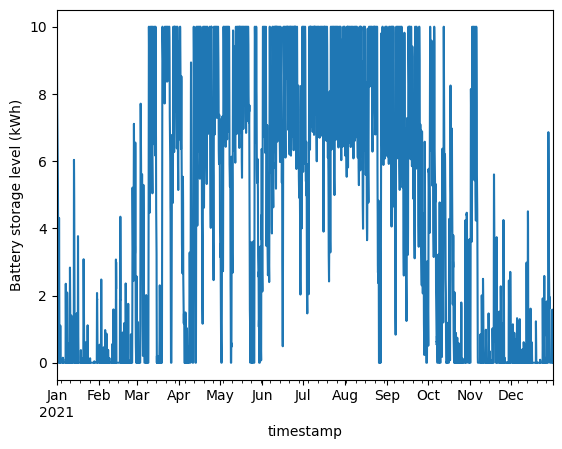

In [9]:
outputd["battery_stored_kWh"].plot()
plt.ylabel('Battery storage level (kWh)')
plt.show()

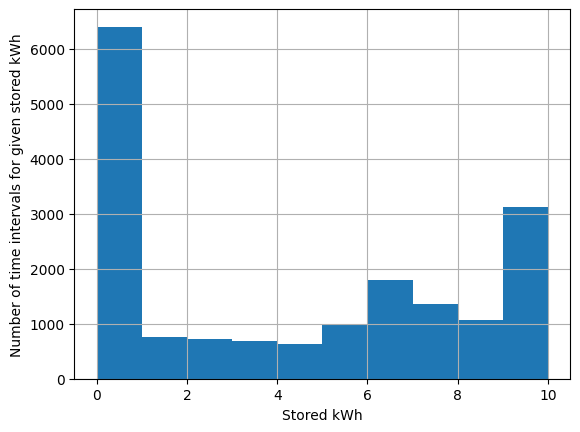

In [10]:
outputd["battery_stored_kWh"].hist()
plt.xlabel('Stored kWh')
plt.ylabel('Number of time intervals for given stored kWh')
plt.show()